<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#TODOs" data-toc-modified-id="TODOs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>TODOs</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)
pd.set_option('max_columns', 100)

In [2]:
court_data = pd.concat([pd.read_csv(f'../state/VA/VA_jail_data/circuit_criminal_{year}_anon_00.csv') for year in range(2010,2020)])
                      
court_data = court_data.drop(
    ['HearingJury', 'HearingPlea', 'HearingRoom', 'fips', 'Locality', 'DrivingRestrictions', 
     'RestrictionEffectiveDate', 'RestrictionEndDate', 'RestitutionPaid', 
     'RestitutionAmount', 'Military', 'TrafficFatality', 'Sex', 'Race', 'Address', 'Costs', 
     'FinesCostPaid', 'ProgramType', 'CourtDMVSurrender', 'DriverImprovementClinic', 'VAAlcoholSafetyAction', 
     'OffenseDate', 'ConcurrentConsecutive', 'LifeDeath', 'OperatorLicenseSuspensionTime', 'FineAmount', 'ArrestDate',
     'AmendedCharge', 'AmendedCodeSection', 'AmendedChargeType', 'ConcludedBy', 'DispositionDate'], axis=1)
court_data = court_data[court_data.DispositionCode == 'Guilty'].drop('DispositionCode', axis=1)
print(f"number of records: {len(court_data)}")
court_data.head()

court_data = court_data[(court_data.HearingResult == 'Sent') | (court_data.HearingResult == 'Sentenced')]
court_data.SentenceTime = court_data.SentenceTime.fillna(0)
court_data.SentenceSuspended = court_data.SentenceSuspended.fillna(0)
court_data['effective_sentence_months'] = (court_data.SentenceTime - court_data.SentenceSuspended) / 365 * 12
court_data = court_data[court_data.Charge.notnull()]


/var/folders/59/dw0km17d3_zfls9_lp1s5vnr0000gn/T/ipykernel_98996/38401820.py:1: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  court_data = pd.concat([pd.read_csv(f'../state/VA/VA_jail_data/circuit_criminal_{year}_anon_00.csv') for year in range(2010,2020)])


number of records: 791960


In [3]:
court_data['day'] = court_data.HearingDate.apply(lambda x: int(x.split('-')[2]))
court_data['month'] = court_data.HearingDate.apply(lambda x: int(x.split('-')[1]))
court_data['year'] = court_data.HearingDate.apply(lambda x: int(x.split('-')[0]))

In [10]:
def get_most_serious_case(df):
    most_serious_crime = df.sort_values('effective_sentence_months').iloc[-1]
    most_serious_crime['crimes'] = len(df)
    return most_serious_crime

court_data = court_data.groupby(['person_id', 'HearingDate'], as_index=False).apply(get_most_serious_case)
court_data.to_csv('/Users/elliedunn/Desktop/SDC/deduped_va_court_data.csv')

In [92]:
#Change JailPenitentiary to say either prison or jail. People who were previously marked as 'Time Served' were
#marked as jail if they were conviced of a misdemeanor or a felony with sentence length less than or equal to 12 
#months. Otherwise they were put in jail 
court_data = court_data[court_data.effective_sentence_months > 0.5]
court_data['time_step'] = (court_data.year - 2019) * 12 + court_data.month
court_data['compartment_duration'] = court_data.effective_sentence_months.round()

test_data = court_data 
test_data.loc[(test_data.JailPenitentiary == 'Time Served') &
                ((test_data.ChargeType == 'Misdemeanor') | 
                 ((test_data.ChargeType == 'Felony') & (test_data.effective_sentence_months <= 12))), 'JailPenitentiary'] = 'jail'
test_data['JailPenitentiary'].replace({"Penitentiary" : "prison", "Jail" : "jail", "Time Served" : "prison"}, inplace = True)
test_data.JailPenitentiary.value_counts()
jail_data = test_data[test_data.JailPenitentiary == 'jail']
prison_data = test_data[test_data.JailPenitentiary == 'prison']
jail_data

,HearingDate,HearingResult,HearingType,Filed,Commencedby,Charge,CodeSection,ChargeType,Class,JailPenitentiary,SentenceTime,SentenceSuspended,ProbationType,ProbationTime,ProbationStarts,AppealedDate,person_id,effective_sentence_months,day,month,year,crimes,time_step,compartment_duration
7,2011-08-04,Sent,Trial,2011-03-28,General District Court Appeal,RECKLESS DRIVING 94/70,C.46.2-862,Misdemeanor,NaN,jail,180.0,150.0,NaN,NaN,NaN,NaN,1000000000308,0.986301,4,8,2011,1,-88,1.0
22,2011-03-29,Sent,Trial,2010-12-08,General District Court Appeal,DRIVE WHILE REV/SUSP,B.46.2-301,Misdemeanor,1,jail,90.0,30.0,NaN,NaN,NaN,NaN,1000000000793,1.972603,29,3,2011,1,-93,2.0
37,2010-09-13,Sent,Trial,2010-06-07,Direct Indictment,DIST MARIJUANA,18.2-248.1,Misdemeanor,1,jail,365.0,180.0,NaN,NaN,NaN,NaN,1000000001347,6.082192,13,9,2010,1,-99,6.0
44,2010-09-07,Sent,Plea,2010-06-21,Direct Indictment,H.O.-PETIT LARCENY,18.2-104,Felony,U,jail,360.0,0.0,NaN,NaN,NaN,NaN,1000000001672,11.835616,7,9,2010,1,-99,12.0
49,2013-01-03,Sent,Plea,2012-09-21,Indictment,DR AFTER DECLARED H.O.-2ND +,46.2-357,Felony,U,jail,330.0,90.0,Unsupervised,730.0,Release,NaN,1000000001695,7.890411,3,1,2013,1,-71,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372886,2015-03-12,Sent,Trial,2014-12-11,Indictment,"OTHER FAIL TO REGIST, 2ND OFF",18.2-472.1,Felony,6,jail,365.0,180.0,NaN,NaN,NaN,NaN,366220000000450,6.082192,12,3,2015,1,-45,6.0
372927,2010-12-07,Sent,Trial,2010-10-26,General District Court Appeal,PETIT LARCENY,18.2-96,Misdemeanor,1,jail,30.0,0.0,NaN,NaN,NaN,NaN,366221000000537,0.986301,7,12,2010,1,-96,1.0
372928,2011-10-11,Sent,Pre-Sentence Report,2011-04-11,Indictment,GRAND LARCENY,18.2-95,Felony,U,jail,365.0,315.0,Supervised,365.0,Release,NaN,366221000000537,1.643836,11,10,2011,1,-86,2.0
372931,2011-11-28,Sent,Trial,2011-09-01,J&Dr Appeal,ASSAULT & BATTERY,18.2-57.2,Misdemeanor,NaN,jail,365.0,0.0,NaN,NaN,NaN,NaN,366240000000010,12.000000,28,11,2011,1,-85,12.0


# Preprocessing

## TODOs
* can't just drop 0 length sentences
* recidivism
* separate out jail
* total population (2019/2020 by month)

In [76]:
court_data.head()

,HearingDate,HearingResult,HearingType,Filed,Commencedby,Charge,CodeSection,ChargeType,Class,JailPenitentiary,SentenceTime,SentenceSuspended,ProbationType,ProbationTime,ProbationStarts,AppealedDate,person_id,effective_sentence_months,day,month,year,crimes
2,2017-09-28,Sent,Trial,2017-04-24,Direct Indictment,"PWI = 40,000 CIG, 2+",58.1-1017.1,Felony,5,prison,1825.0,1670.0,NaN,NaN,NaN,NaN,1000000000169,5.095890,28,9,2017,1
7,2011-08-04,Sent,Trial,2011-03-28,General District Court Appeal,RECKLESS DRIVING 94/70,C.46.2-862,Misdemeanor,NaN,jail,180.0,150.0,NaN,NaN,NaN,NaN,1000000000308,0.986301,4,8,2011,1
10,2011-03-02,Sent,Pre-Sentence Report,2010-08-18,Indictment,DUI 4+ W/10 YEARS,C.18.2-266,Felony,NaN,prison,1825.0,1275.0,NaN,NaN,NaN,NaN,1000000000362,18.082192,2,3,2011,1
11,2016-05-16,Sent,Pre-Sentence Report,2015-10-09,Indictment,DWI-3RD OFF W/IN 10Y,C.18.2-266,Felony,6,prison,1825.0,1275.0,NaN,NaN,NaN,2016-06-29,1000000000362,18.082192,16,5,2016,1
12,2016-07-08,Sent,Pre-Sentence Report,2015-10-30,Indictment,DWI: 4+ OFF W/IN 10Y,F.18.2-266,Felony,6,prison,365.0,0.0,NaN,NaN,NaN,NaN,1000000000362,12.000000,8,7,2016,1


In [93]:
outflows_jail = jail_data.groupby('time_step').count()[['HearingType']].reset_index().rename(
    {'HearingType': 'total_population'}, axis=1
)
outflows_prison = prison_data.groupby('time_step').count()[['HearingType']].reset_index().rename(
    {'HearingType': 'total_population'}, axis=1
)
outflows_jail['outflow_to'] = 'jail'
outflows_prison['outflow_to'] = 'prison'
outflows_data = pd.concat([outflows_prison, outflows_jail], axis=0)

outflows_data['compartment'] = 'pretrial'
outflows_data['crime_type'] = 'NA'
outflows_data = outflows_data[outflows_data['time_step'] < 12]
outflows_data.time_step = outflows_data.time_step.astype(int)
outflows_data.total_population = outflows_data.total_population.astype(float)
outflows_data

,time_step,total_population,outflow_to,compartment,crime_type
0,-107,1276.0,prison,pretrial,NA
1,-106,1071.0,prison,pretrial,NA
2,-105,1448.0,prison,pretrial,NA
3,-104,1149.0,prison,pretrial,NA
4,-103,1133.0,prison,pretrial,NA
5,-102,1349.0,prison,pretrial,NA
6,-101,1084.0,prison,pretrial,NA
7,-100,1216.0,prison,pretrial,NA
8,-99,1190.0,prison,pretrial,NA
9,-98,1145.0,prison,pretrial,NA


<AxesSubplot:xlabel='time_step'>

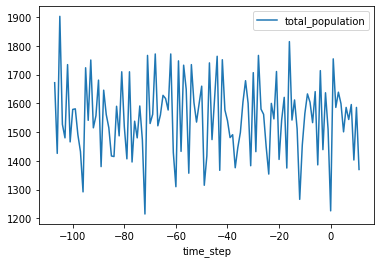

In [82]:
outflows_data.groupby('time_step').sum().plot()

In [95]:
transitions_jail = jail_data.groupby(
    'compartment_duration'
).count()[['HearingType']].reset_index().rename({'HearingType': 'total_population'}, axis=1)

transitions_prison = prison_data.groupby(
    'compartment_duration'
).count()[['HearingType']].reset_index().rename({'HearingType': 'total_population'}, axis=1)

transitions_jail['compartment'] = 'jail'
transitions_prison['compartment'] = 'prison'
transitions_data = pd.concat([transitions_prison, transitions_jail], axis=0)

transitions_data['outflow_to'] = 'release'
transitions_data['crime_type'] = 'NA'

transitions_data = transitions_data.append(pd.DataFrame({
    'compartment_duration': [24],
    'total_population': [1],
    'compartment': ['release'],
    'outflow_to': ['release'],
    'crime_type': ['NA'],
}), ignore_index=True)

transitions_data.total_population = transitions_data.total_population.astype(float)
transitions_data

,compartment_duration,total_population,compartment,outflow_to,crime_type
0,1.0,8367.0,prison,release,NA
1,2.0,6867.0,prison,release,NA
2,3.0,13230.0,prison,release,NA
3,4.0,4344.0,prison,release,NA
4,5.0,2266.0,prison,release,NA
5,6.0,14942.0,prison,release,NA
6,7.0,4785.0,prison,release,NA
7,8.0,2913.0,prison,release,NA
8,9.0,4249.0,prison,release,NA
9,10.0,2615.0,prison,release,NA


In [24]:
simulation_tag = "ETC_nov_11"

upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    outflows_data,
    transitions_data,
    pd.DataFrame(),
    '../state/VA/2022/policy_configurations/ETC_model_inputs.yaml',
)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


# Modeling

In [25]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../state/VA/2022/policy_configurations/ETC_model_inputs.yaml'
)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1852: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


outflows_data returned 119 results
transitions_data returned 351 results
total_population_data returned 0 results


initialization time:  41.003061056137085
simulation_time:  6.35130500793457


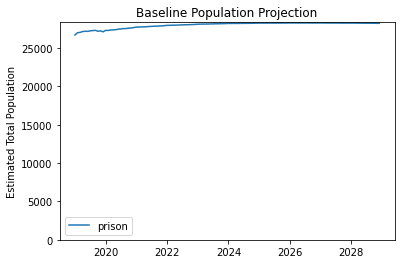

In [26]:
spark_sim.simulate_baseline(['prison'])

[<AxesSubplot:title={'center':'compartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>]

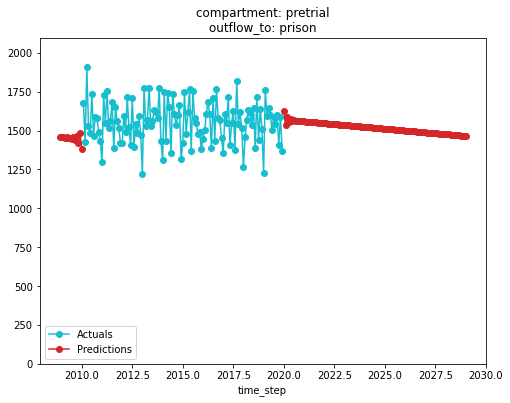

In [32]:
spark_sim.get_arima_output_plots('baseline_projections')

initialization time:  11.501911163330078
initialization time:  11.286267757415771
simulation_time:  12.895094156265259
simulation_time:  13.650649070739746


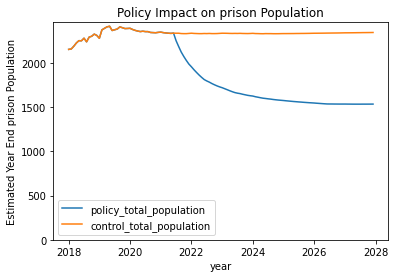

In [26]:
# Legalize drug possession

def legalize_pot():
    return partial(ShellCompartment.reallocate_outflow, 
                   reallocation_fraction=1,
                   outflow='prison',
                   new_outflow=None)

policy_list = [SparkPolicy(policy_fn=legalize_pot(),
                                           spark_compartment='pretrial',
                                           sub_population={'crime': 'possession'},
                                           policy_ts=18,
                                           apply_retroactive=False),
#                SparkPolicy(policy_fn=legalize_pot(),
#                                            spark_compartment='pretrial',
#                                            sub_population={'crime': 'sale'},
#                                            policy_ts=24,
#                                            apply_retroactive=False),
              ]
    
test_results = spark_sim.simulate_policy(policy_list, 'prison')

In [4]:
# maybe don't run this one yourself, no need to spam our output database :)
simulation_tag = 'VA_cannabis_possession_oct_28'
spark_sim.upload_policy_simulation_results_to_bq(simulation_tag)

{'spending_diff':                       prison release
 year                                
 2018.000000              0.0     0.0
 2018.083333              0.0     0.0
 2018.166667              0.0     0.0
 2018.250000              0.0     0.0
 2018.333333              0.0     0.0
 2018.416667              0.0     0.0
 2018.500000              0.0     0.0
 2018.583333              0.0     0.0
 2018.666667              0.0     0.0
 2018.750000              0.0     0.0
 2018.833333              0.0     0.0
 2018.916667              0.0     0.0
 2019.000000              0.0     0.0
 2019.083333              0.0     0.0
 2019.166667              0.0     0.0
 2019.250000              0.0     0.0
 2019.333333              0.0     0.0
 2019.416667              0.0     0.0
 2019.500000              0.0     0.0
 2019.583333              0.0     0.0
 2019.666667              0.0     0.0
 2019.750000              0.0     0.0
 2019.833333              0.0     0.0
 2019.916667              0.0    

In [11]:
test_results

,compartment,year,policy_total_population,simulation_group,control_total_population
year,,,,,
2018.000000,prison,2018.000000,29.265817,other,29.265817
2018.083333,prison,2018.083333,27.138253,other,27.138253
2018.166667,prison,2018.166667,31.450119,other,31.450119
2018.250000,prison,2018.250000,30.977326,other,30.977326
2018.333333,prison,2018.333333,30.788209,other,30.788209
...,...,...,...,...,...
2027.583333,release,2027.583333,25094.273587,sale,25094.273587
2027.666667,release,2027.666667,25209.085195,sale,25209.085195
2027.750000,release,2027.750000,25323.827219,sale,25323.827219
